## Compare the two scheme MP and what is used here

For MP, FeS is computed using GGA and GGA+U entries have been corrected using the factors

Note that these are not what used in the calculation below by default - those data are extract from JANNAF table.



| Compound | kcal / mol | eV
| ---------- | ---- | ---- |
|FeS    |-24	|-1.040712
|FeS2	|-41	|-1.777883
|Fe3O4	|-266.9	|-11.5735847
|Fe2O3	|-196.3	|-8.5121569
|FeO	|-63.2	|-2.7405416
|Li2O   |-142.6 | -6.18356
|Li2S   | -106.7 | -4.62683 

The data in the json file are extracted from the *Kubaschewski Table*.
Running will require an AiiDA profile with the data imported as reactions are directly loaded from the database.  
However, it is possible to replot the summary using saved data.

In [1]:
%aiida

Loaded AiiDA DB environment - profile name: quicksetup.

In [2]:
from pymatgen.ext.matproj import MPRester
from monty.serialization import loadfn
from pymatgen.analysis.reaction_calculator import ComputedReaction, ComputedEntry


In [3]:
def load_from_table():
    data = """
Compound 	kcal / mol 	eV
FeS 	-24 	-1.040712
FeS2 	-41 	-1.777883
Fe3O4 	-266.9 	-11.5735847
Fe2O3 	-196.3 	-8.5121569
FeO 	-63.2 	-2.7405416
Li2O 	-142.6 	-6.18356
Li2S 	-106.7 	-4.62683"""

    entries_exp = {}
    for line in data.split('\n')[2:]:
        comp, _, eng = line.split()
        entries_exp[comp] = ComputedEntry(comp, float(eng))
    return entries_exp

# Data from the K
entries_exp = {entry.composition.reduced_formula : entry for entry in loadfn('experimental.json')[0]}
#entries_exp = load_from_table()  # Uncomment to use the JANNAF table data
entries_comp = {entry.composition.reduced_formula : entry for entry in loadfn('computed-this-work.json')[0]}
o2_comp = ComputedEntry('O2', -9.8868095, correction=1.33)
entries_comp['O2'] = o2_comp
entries_exp['Fe'] = ComputedEntry('Fe', 0.0)
entries_exp['O2'] = ComputedEntry('O2', 0.0)
entries_exp['S'] = ComputedEntry('S', 0.0)


In [4]:
from pymatgen.entries.compatibility import MaterialsProject2020Compatibility, MaterialsProjectCompatibility, MODULE_DIR
from monty.serialization import dumpfn, loadfn

In [5]:
# Load the entries from the saved JSON file
mp_entries_2020 = loadfn('mp-entry-data.json')
mp_entries_previous = loadfn('mp-entry-data.json')

/home/bonan/miniconda3/envs/aiida/lib/python3.8/site-packages/monty/json.py:176: FutureWarning: __init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020
  return cls(**decoded)


In [6]:
# Patch the compatibility file
# Because the exact fitting values of the MP2020Compatibility appears to be reivsed between different MP versions
# The MP2020Compatibility.yaml in the current dir is downloaded from version 2022.0.8 and will be applied to the pymatgen installation directory!
import shutil
from pathlib import Path
filepath = Path(MODULE_DIR) / "MP2020Compatibility.yaml"
! diff {filepath} MP2020Compatibility.yaml

In [7]:
shutil.move(Path(MODULE_DIR) / 'MP2020Compatibility.yaml', Path(MODULE_DIR) / 'MP2020Compatibility.yaml.bak')
shutil.copy2('MP2020Compatibility.yaml', Path(MODULE_DIR) / 'MP2020Compatibility.yaml')

PosixPath('/home/bonan/miniconda3/envs/aiida/lib/python3.8/site-packages/pymatgen/entries/MP2020Compatibility.yaml')

In [8]:
! diff {filepath} MP2020Compatibility.yaml

In [9]:
mp_entries_2020 = {
    key: MaterialsProject2020Compatibility().process_entry(value) for key, value in mp_entries_2020.items()
}
mp_entries_orig = {
    key: MaterialsProjectCompatibility().process_entry(value) for key, value in mp_entries_previous.items()
}

<ipython-input-9-a66e94c91335>:5: FutureWarning: __init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020
  key: MaterialsProjectCompatibility().process_entry(value) for key, value in mp_entries_previous.items()


## Entries using our correction

In [10]:
from toolchest.hull import get_relax_record_single
from copy import deepcopy
from toolchest.hull import get_relax_records, get_entry

factor = -1.787  # Factor to convert GGAU to GGA, fitting for Fe U=4.0 
new_entries = {}
for entry in entries_comp.values():
    new_entry = deepcopy(entry)
    if 'Fe' in entry.composition:
        new_entry.correction = entry.composition['Fe'] * factor 
        new_entries[entry.composition.reduced_formula] = new_entry
    else:
        new_entries[entry.composition.reduced_formula] = new_entry

# Get the FeS, FeS2 without U
df = get_relax_records([Group.objects.get(label='li-fe-o-s/mp-structures')], 520)
df = df[df.functional == 'pbe']

formula = 'FeS'
subset = df[df.formula == formula]
mask = subset.umap.apply(lambda x: x['Fe'] == 0)
subset = subset[mask]
extra_entires = get_entry(subset)
extra_entires.sort(key = lambda x: x.energy_per_atom)
new_entries[formula] = extra_entires[0]

formula = 'FeS2'
subset = df[df.formula == formula]
mask = subset.umap.apply(lambda x: x['Fe'] == 0)
subset = subset[mask]
extra_entires = get_entry(subset)
extra_entires.sort(key = lambda x: x.energy_per_atom)
new_entries[formula] = extra_entires[0]


formula = 'Fe'
subset = df[df.formula == formula]
mask = subset.umap.apply(lambda x: x['Fe'] == 0)
subset = subset[mask]
extra_entires = get_entry(subset)
extra_entires.sort(key = lambda x: x.energy_per_atom)
new_entries[formula] = extra_entires[0]

entries_comp_refit = new_entries

Entries: 105


  0%|          | 0/105 [00:00<?, ?it/s]

## Save the entries in the json format

## Load the entries from save files

In [19]:
entires_exp = loadfn('saved_entries/entries_exp.json')
entries_comp = loadfn('saved_entries/entries_comp.json')
entries_comp_refit = loadfn('saved_entries/entries_comp_refit.json')
mp_entires_orig = loadfn('saved_entries/mp_entires_orig.json')
mp_entries_2020 = loadfn('saved_entries/mp_entires_2020.json')

/home/bonan/miniconda3/envs/aiida/lib/python3.8/site-packages/monty/json.py:176: FutureWarning: __init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020
  return cls(**decoded)


## Compute the reaction energies and add to dictionary

In [11]:
def print_and_add(entries, labels, collection):
    """Print energy and add to the dictionary"""
    reactant = [entries[l] for l in labels[0]]
    product = [entries[l] for l in labels[1]]
    react = ComputedReaction(reactant, product)
    print(f'{str(react):<60} energy: {react.calculated_reaction_energy:<10.2f} eV')
    collection[f'{str(react)}'] = react
    
def print_result(entries, collection):
    """Print energy and add to the dictionary"""
    print_and_add(entries, [['FeS', 'Li2O'], ['FeO', 'Li2S']], collection)
    print_and_add(entries, [['FeS2', 'FeO'], ['FeS', 'Fe2O3']], collection)
    print_and_add(entries, [['FeS2', 'FeO'], ['FeS', 'Fe3O4']], collection)
    return collection

def print_fe_formations(entries, collection):
    """Print energy and add to the dictionary"""
    print_and_add(entries, [['Fe', 'O2'], ['FeO']], collection)
    print_and_add(entries, [['Fe', 'O2'], ['Fe2O3']], collection)
    print_and_add(entries, [['Fe', 'O2'], ['Fe3O4']], collection)
    
def print_fe_reactions(entries, collection):
    """Print energy and add to the dictionary"""
    print_and_add(entries, [['FeO', 'O2'], ['Fe2O3']], collection)
    print_and_add(entries, [['FeO', 'O2'], ['Fe3O4']], collection)
    print_and_add(entries, [['Fe3O4', 'O2'], ['Fe2O3']], collection)


In [12]:
collection_exp = {}
collection_comp = {}
collection_comp_refit = {}
collection_mp_2020 = {}
collection_mp_orig = {}

print('EXP')
print_result(entries_exp, collection_exp)

print('THIS WORK')
print_result(entries_comp, collection_comp)

print('THIS WORK - REFIT')
print_result(entries_comp_refit, collection_comp_refit)

print('MP-ORIG')
print_result(mp_entries_orig, collection_mp_orig)

print('MP-2020')
print_result(mp_entries_2020, collection_mp_2020)



EXP
FeS + Li2O -> FeO + Li2S                                     energy: -0.19      eV
0.5 FeS2 + 1.5 FeO -> FeS + 0.5 Fe2O3                        energy: -0.21      eV
0.5 FeS2 + 2 FeO -> FeS + 0.5 Fe3O4                          energy: -0.33      eV
THIS WORK
FeS + Li2O -> FeO + Li2S                                     energy: -0.37      eV
0.5 FeS2 + 1.5 FeO -> FeS + 0.5 Fe2O3                        energy: -0.46      eV
0.5 FeS2 + 2 FeO -> FeS + 0.5 Fe3O4                          energy: -0.56      eV
THIS WORK - REFIT
FeS + Li2O -> FeO + Li2S                                     energy: 0.46       eV
0.5 FeS2 + 1.5 FeO -> FeS + 0.5 Fe2O3                        energy: -0.32      eV
0.5 FeS2 + 2 FeO -> FeS + 0.5 Fe3O4                          energy: -0.42      eV
MP-ORIG
FeS + Li2O -> FeO + Li2S                                     energy: -0.25      eV
0.5 FeS2 + 1.5 FeO -> FeS + 0.5 Fe2O3                        energy: 0.17       eV
0.5 FeS2 + 2 FeO -> FeS + 0.5 Fe3O4            

{'FeS + Li2O -> FeO + Li2S': FeS + Li2O -> FeO + Li2S,
 '0.5 FeS2 + 1.5 FeO -> FeS + 0.5 Fe2O3': 0.5 FeS2 + 1.5 FeO -> FeS + 0.5 Fe2O3,
 '0.5 FeS2 + 2 FeO -> FeS + 0.5 Fe3O4': 0.5 FeS2 + 2 FeO -> FeS + 0.5 Fe3O4}

## Compute the reactions energies for GGU fitting

In [13]:
print('EXP')
print_fe_reactions(entries_exp, collection_exp)
print('THIS WORK')
print_fe_reactions(entries_comp, collection_comp)
print('THIS WORK - REFIT')
print_fe_reactions(entries_comp_refit, collection_comp_refit)
print('MP')
print_fe_reactions(mp_entries_orig, collection_mp_orig)
print('MP-2020')
print_fe_reactions(mp_entries_2020, collection_mp_2020)

EXP
2 FeO + 0.5 O2 -> Fe2O3                                      energy: -2.92      eV
3 FeO + 0.5 O2 -> Fe3O4                                      energy: -3.16      eV
0.6667 Fe3O4 + 0.1667 O2 -> Fe2O3                            energy: -0.81      eV
THIS WORK
2 FeO + 0.5 O2 -> Fe2O3                                      energy: -2.91      eV
3 FeO + 0.5 O2 -> Fe3O4                                      energy: -3.11      eV
0.6667 Fe3O4 + 0.1667 O2 -> Fe2O3                            energy: -0.84      eV
THIS WORK - REFIT
2 FeO + 0.5 O2 -> Fe2O3                                      energy: -2.91      eV
3 FeO + 0.5 O2 -> Fe3O4                                      energy: -3.11      eV
0.6667 Fe3O4 + 0.1667 O2 -> Fe2O3                            energy: -0.84      eV
MP
2 FeO + 0.5 O2 -> Fe2O3                                      energy: -2.62      eV
3 FeO + 0.5 O2 -> Fe3O4                                      energy: -2.53      eV
0.6667 Fe3O4 + 0.1667 O2 -> Fe2O3                   

## Compute the GGA+U / GGA mixing fitting reactions

In [14]:
print('EXP')

print_fe_formations(entries_exp, collection_exp)
print('THIS WORK')

print_fe_formations(entries_comp, collection_comp)
print('THIS WORK - REFIT')

print_fe_formations(entries_comp_refit, collection_comp_refit)
print('MP')

print_fe_formations(mp_entries_orig, collection_mp_orig)

print('MP-2020')
print_fe_formations(mp_entries_2020, collection_mp_2020)

EXP
Fe + 0.5 O2 -> FeO                                           energy: -2.82      eV
2 Fe + 1.5 O2 -> Fe2O3                                       energy: -8.55      eV
3 Fe + 2 O2 -> Fe3O4                                         energy: -11.61     eV
THIS WORK
Fe + 0.5 O2 -> FeO                                           energy: -4.02      eV
2 Fe + 1.5 O2 -> Fe2O3                                       energy: -10.96     eV
3 Fe + 2 O2 -> Fe3O4                                         energy: -15.18     eV
THIS WORK - REFIT
Fe + 0.5 O2 -> FeO                                           energy: -2.79      eV
2 Fe + 1.5 O2 -> Fe2O3                                       energy: -8.48      eV
3 Fe + 2 O2 -> Fe3O4                                         energy: -11.47     eV
MP
Fe + 0.5 O2 -> FeO                                           energy: -3.46      eV
2 Fe + 1.5 O2 -> Fe2O3                                       energy: -9.54      eV
3 Fe + 2 O2 -> Fe3O4                                

## Assemble a table

In [15]:
import pandas as pd

In [16]:
def convert_to_entry(collection, kind):
    """Convert reactions to  records """
    out = []
    for key, value in collection.items():
        out.append({
            'reaction': value,
            'reactants': value.reactants,
            'product': value.products,
            'energy': value.calculated_reaction_energy,
            'kind': kind,
            'name': key,
        })
    return out

In [17]:
# Construct the rows of a table
entries = []
for collection, kind in zip([collection_exp, collection_comp, collection_comp_refit, collection_mp_orig, collection_mp_2020], 
                            ['Experimental', 'All', 'Oxide only', 'MP-ORIG', 'MP-2020']):
    entries.extend(convert_to_entry(collection, kind))

## Plot the summary stable

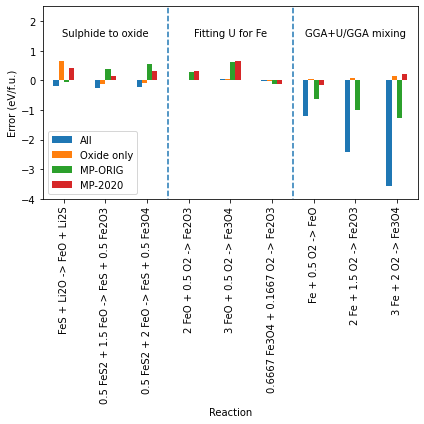

In [18]:
# Construct a summary table
summary = pd.DataFrame(entries).set_index('reaction')

# Uncomment below to use the save data for plotting
#summary = pd.read_csv('summary-table.csv').set_index('reaction')
summary.to_csv('summary-table.csv')

summary['Error'] = 0

for kind in ['All', 'Oxide only', 'MP-ORIG', 'MP-2020']:
    subset = summary.loc[summary.kind == kind]
    summary.loc[summary.kind == kind, 'Error'] = subset['energy'] - summary[summary.kind == 'Experimental'].energy
summary = summary.set_index([summary.index, 'kind'])

# Plot the results, but first we need to get rid of the experimetnal line
filtered = summary[summary.index.isin(['All', 'Oxide only', 'MP-ORIG', 'MP-2020'], level=1)]
fig, ax = plt.subplots(1,1, figsize=(6, 6))
filtered.unstack().plot.bar(y='Error', ax=ax)
plt.ylabel('Error (eV/f.u.)')
plt.xlabel('Reaction')
plt.vlines(2.5, -5, 3, linestyles='dashed')
plt.vlines(5.5, -5, 3, linestyles='dashed')
plt.annotate(r'Sulphide to oxide', (1, 1.5), ha='center')
plt.annotate(r'Fitting U for Fe', (4, 1.5), ha='center')
plt.annotate(r'GGA+U/GGA mixing', (7,  1.5), ha='center')
plt.legend(loc=3)
plt.ylim(-4, 2.5)
plt.tight_layout()
plt.savefig('fitting-summary.svg')
plt.savefig('fitting-summary.png')
#plt.savefig('../../../Li-Fe-S-O-paper/Figures/fitting-summary.png', dpi=200)
#plt.savefig('../../../Li-Fe-S-O-paper/Figures/fitting-summary.svg')


## Some remarks
Energies obtained from KB table, although using the JANNF table should give very similar results. 

About the new 2020 class:
1. The data is still not properly fitted (which would mean they have to recompute all Fe compounds); 
2. When done properly, one does not want to use their GGA/GGA+U mixing scheme to compared cross oxide/sulphides.


# NOTE
Future version of `pymatgen` will redefine the `MateiralsProjectCompatibility` class and point it to the new 2020 scheme. The old scheme should still be accessible but under a different name.